### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

![lda](lda_simple.png "LDA")

ист. https://habr.com/ru/company/surfingbird/blog/230103/

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### ПЕРЕРЫВ ДО 21:02 (МСК)

### Переходим к практике

In [7]:
import pandas as pd

Наши новости

In [8]:
news = pd.read_csv("/content/materials.csv", engine="python") # articles.csv
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [9]:
users = pd.read_csv("/content/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [10]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [11]:
!pip install razdel pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 8.2 MB 13.8 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=efab26efba62f4a5364986f59e2e3da32428ad3f453323bd4ead34ad0926b6f8
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


In [12]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [15]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [16]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [17]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-16-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


CPU times: user 34.2 s, sys: 2.17 s, total: 36.3 s
Wall time: 44.8 s


In [18]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 59s, sys: 713 ms, total: 3min 59s
Wall time: 4min 1s


А теперь в 3 строчки обучим нашу модель

In [19]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [20]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [21]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 46.2 s, sys: 21.9 s, total: 1min 8s
Wall time: 43.8 s


In [22]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [23]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(17, 0.9765854)]

In [24]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: россия банк российский рост nn наука эксперт
topic_1: nn учёный взрыв проверка заболевание опубликовать тело
topic_2: ребёнок клетка мозг обнаружить лицо рубль уголовный
topic_3: сша американский учёный миссия nasa трамп орбита
topic_4: цена день мероприятие температура посетитель билет учёный
topic_5: украина украинский экономический российский россия крым ес
topic_6: налог авиакомпания министерство остров конкурс глава риск
topic_7: ракета фонд восток британский фильм великобритания млн
topic_8: проект млрд исследование рубль новый программа руб
topic_9: рак риск метод кровь геном доллар nn
topic_10: гражданин россиянин nn снижение рейс белоруссия место
topic_11: млн стоимость продукция животное новый тыс городской
topic_12: учёный научный северный университет обнаружить опубликовать южный
topic_13: космический корабль технология запуск роскосмос космос спутник
topic_14: самолёт экономика нефть полёт армия операция россия
topic_15: исследователь жизнь женщина век всё автор п

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [25]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [26]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.938027,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.044438,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,4896,0.000000,0.645828,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.331733,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,4897,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.000000,0.0,0.976585,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,4898,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.046301,0.0,0.466319,0.0,0.0,0.0,0.0,0.0,0.0,0.476904
4,4899,0.268455,0.000000,0.0,0.0,0.0,0.0,0.0,0.06255,0.0,...,0.000000,0.0,0.116999,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [27]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [28]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [29]:
doc_dict[293622]

array([0.        , 0.10136925, 0.15856908, 0.        , 0.17204928,
       0.        , 0.        , 0.07923318, 0.        , 0.04078589,
       0.01666493, 0.        , 0.04557231, 0.        , 0.        ,
       0.        , 0.04847671, 0.15762107, 0.        , 0.        ,
       0.        , 0.04181715, 0.02272001, 0.10141708, 0.        ])

In [30]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [31]:
get_user_embedding(user_articles_list)

array([0.18716787, 0.09378541, 0.14574042, 0.09412808, 0.        ,
       0.04461601, 0.01421521, 0.        , 0.0182828 , 0.        ,
       0.00967194, 0.        , 0.        , 0.00694903, 0.0480928 ,
       0.00255514, 0.09300104, 0.03044105, 0.04064438, 0.01435156,
       0.01656339, 0.05417466, 0.00889891, 0.02893836, 0.03795088])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [32]:
#users['articles'].iloc[33]

In [33]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [34]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.054032,0.120401,0.012000,0.109558,0.035406,0.034682,0.051983,0.075404,...,0.030088,0.049449,0.055283,0.055077,0.010871,0.000000,0.012133,0.030184,0.016903,0.027192
1,u108690,0.067162,0.037090,0.136379,0.051903,0.009500,0.122481,0.026520,0.017401,0.022999,...,0.036160,0.134196,0.045836,0.022114,0.020611,0.031198,0.012611,0.059614,0.020009,0.089798
2,u108339,0.065208,0.110744,0.143241,0.004142,0.012909,0.039825,0.010637,0.002273,0.032238,...,0.013329,0.121313,0.021471,0.099587,0.023242,0.012069,0.108571,0.000000,0.018815,0.086028


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [35]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [36]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.054032,0.120401,0.012000,0.109558,0.035406,0.034682,0.051983,0.075404,...,0.049449,0.055283,0.055077,0.010871,0.000000,0.012133,0.030184,0.016903,0.027192,0
1,u108690,0.067162,0.037090,0.136379,0.051903,0.009500,0.122481,0.026520,0.017401,0.022999,...,0.134196,0.045836,0.022114,0.020611,0.031198,0.012611,0.059614,0.020009,0.089798,1
2,u108339,0.065208,0.110744,0.143241,0.004142,0.012909,0.039825,0.010637,0.002273,0.032238,...,0.121313,0.021471,0.099587,0.023242,0.012069,0.108571,0.000000,0.018815,0.086028,1


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [39]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [40]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09617649, 0.02362875, 0.56445016, 0.15477731, 0.03604353,
       0.0673057 , 0.25668151, 0.01115377, 0.03222563, 0.41371222])

In [41]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [42]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.268628, F-Score=0.706, Precision=0.639, Recall=0.788


In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1646  109]
 [  53  192]]


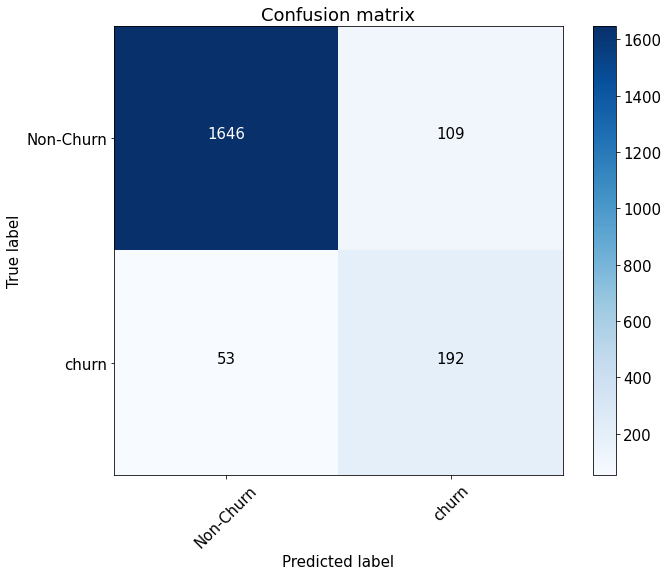

In [45]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
import itertools
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [46]:
roc_auc_score(y_test, preds)

0.9521716378859236

In [119]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9521716378859236

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

In [47]:
# hw
# 1
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())


print(X)

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
  (0, 1)	0.46979138557992045
  (0, 2)	0.5802858236844359
  (0, 6)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 8)	0.38408524091481483
  (1, 5)	0.5386476208856763
  (1, 1)	0.6876235979836938
  (1, 6)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 8)	0.281088674033753
  (2, 4)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 0)	0.511848512707169
  (2, 6)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 8)	0.267103787642168
  (3, 1)	0.46979138557992045
  (3, 2)	0.5802858236844359
  (3, 6)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 8)	0.38408524091481483


In [48]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer

CountVectorizer()

In [49]:
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
]
X = vectorizer.fit_transform(corpus)
X

<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [50]:
analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.") == (
    ['this', 'is', 'text', 'document', 'to', 'analyze'])

True

In [51]:
print(vectorizer.get_feature_names_out())



X.toarray()

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [52]:
vectorizer.vocabulary_.get('document')

1

In [53]:
vectorizer.transform(['Something completely new.']).toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [54]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', min_df=1)
analyze = bigram_vectorizer.build_analyzer()
analyze('Bi-grams are cool!') == (
    ['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool'])

True

In [55]:
X_2 = bigram_vectorizer.fit_transform(corpus).toarray()
X_2

array([[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]])

In [56]:
feature_index = bigram_vectorizer.vocabulary_.get('is this')
X_2[:, feature_index]

array([0, 0, 0, 1])

In [57]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

In [58]:
counts = [[3, 0, 1],
          [2, 0, 0],
          [3, 0, 0],
          [4, 0, 0],
          [3, 2, 0],
          [3, 0, 2]]

tfidf = transformer.fit_transform(counts)
print(tfidf)



print(tfidf.toarray())

  (0, 2)	0.5732079309279059
  (0, 0)	0.8194099510753754
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 1)	0.8808994832762984
  (4, 0)	0.47330339145578754
  (5, 2)	0.8135516873095774
  (5, 0)	0.5814926070688599
[[0.81940995 0.         0.57320793]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.47330339 0.88089948 0.        ]
 [0.58149261 0.         0.81355169]]


In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

<4x9 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [60]:
# 2 
# def get_user_embedding(user_articles_list):
#     user_articles_list = eval(user_articles_list)
#     user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.median(user_vector, 0)
#     return user_vector

# to to the cell with the expression 'get_user_embedding(user_articles_list)'
# we've got smth strange with median: Best Threshold=0.947663, F-Score=nan, Precision=0.000, Recall=0.000

In [61]:
def get_user_embedding_2(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  # медиана
    return user_vector

In [64]:
user_articles_list #= users['articles'].iloc[33]

uv_1 = get_user_embedding(user_articles_list) #
uv_2 = get_user_embedding_2(user_articles_list, doc_dict)

print(user_articles_list)
print(uv_1)
print(uv_2)

[323329, 321961, 324743, 323186, 324632, 474690]
[0.18716787 0.09378541 0.14574042 0.09412808 0.         0.04461601
 0.01421521 0.         0.0182828  0.         0.00967194 0.
 0.         0.00694903 0.0480928  0.00255514 0.09300104 0.03044105
 0.04064438 0.01435156 0.01656339 0.05417466 0.00889891 0.02893836
 0.03795088]
[0.15513717 0.05074601 0.04993362 0.0643983  0.         0.
 0.00798113 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01720217 0.
 0.02296885 0.         0.         0.         0.         0.
 0.01618495]


In [70]:
%%time
N_topic = 25
user_embeddings_2 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_2(x, doc_dict))])
user_embeddings_2.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_2['uid'] = users['uid'].values
user_embeddings_2 = user_embeddings_2[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings_2.head(3)

CPU times: user 689 ms, sys: 18.1 ms, total: 707 ms
Wall time: 722 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.015679,0.148389,0.00000,0.106331,0.021241,0.000000,0.034881,0.026063,...,0.000000,0.024238,0.000000,0.038205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,u108690,0.067570,0.028882,0.059189,0.00808,0.000000,0.124658,0.014471,0.000000,0.007678,...,0.036582,0.136230,0.026339,0.009318,0.019660,0.008266,0.000000,0.011503,0.000000,0.106783
2,u108339,0.047549,0.092618,0.118235,0.00000,0.006648,0.016786,0.000000,0.000000,0.025965,...,0.009150,0.098883,0.023585,0.043370,0.013293,0.005053,0.087115,0.000000,0.011117,0.073915


In [71]:
user_embeddings_2.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.015679,0.148389,0.00000,0.106331,0.021241,0.000000,0.034881,0.026063,...,0.000000,0.024238,0.000000,0.038205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,u108690,0.067570,0.028882,0.059189,0.00808,0.000000,0.124658,0.014471,0.000000,0.007678,...,0.036582,0.136230,0.026339,0.009318,0.019660,0.008266,0.000000,0.011503,0.000000,0.106783
2,u108339,0.047549,0.092618,0.118235,0.00000,0.006648,0.016786,0.000000,0.000000,0.025965,...,0.009150,0.098883,0.023585,0.043370,0.013293,0.005053,0.087115,0.000000,0.011117,0.073915
3,u101138,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.314520,0.000000,0.016699,0.012551,0.012410,0.050070,0.000000,0.000000
4,u108248,0.025527,0.031333,0.046072,0.00000,0.070342,0.040177,0.005045,0.000000,0.023404,...,0.054462,0.049229,0.023671,0.009112,0.006972,0.051761,0.000000,0.000000,0.000000,0.012843


In [72]:
X_2 = pd.merge(user_embeddings_2, target, 'left')
X_2.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.015679,0.148389,0.00000,0.106331,0.021241,0.000000,0.034881,0.026063,...,0.024238,0.000000,0.038205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,u108690,0.067570,0.028882,0.059189,0.00808,0.000000,0.124658,0.014471,0.000000,0.007678,...,0.136230,0.026339,0.009318,0.019660,0.008266,0.000000,0.011503,0.000000,0.106783,1
2,u108339,0.047549,0.092618,0.118235,0.00000,0.006648,0.016786,0.000000,0.000000,0.025965,...,0.098883,0.023585,0.043370,0.013293,0.005053,0.087115,0.000000,0.011117,0.073915,1


In [73]:
# разделим данные на train/test
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_2['churn'], random_state=0)

In [76]:
# logreg_2 = LogisticRegression()
from sklearn.ensemble import RandomForestClassifier
logreg_2 = RandomForestClassifier()
# обучим 
logreg_2.fit(X_2_train, y_2_train)

RandomForestClassifier()

In [77]:
# наши прогнозы для тестовой выборки
preds_2 = logreg_2.predict_proba(X_2_test)[:, 1]
preds_2[:10]

array([0.04, 0.  , 1.  , 0.02, 0.  , 0.04, 0.15, 0.  , 0.  , 0.  ])

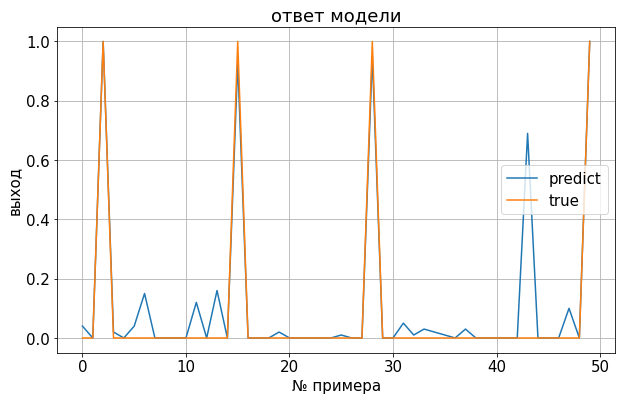

In [78]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds_2[:n], label='predict')
plt.plot(y_2_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [79]:
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_2_test, preds_2)
# print(precision_2 + recall_2)
fscore_2 = (2 * precision_2 * recall_2) / (precision_2 + recall_2)
# locate the index of the largest f score
ix_2 = np.argmax(fscore_2)
print(f'Best Threshold={thresholds_2[ix_2]}, F-Score={fscore_2[ix_2]:.3f}, Precision={precision_2[ix_2]:.3f}, Recall={recall_2[ix_2]:.3f}')      

Best Threshold=0.26, F-Score=0.947, Precision=0.916, Recall=0.980


Confusion matrix, without normalization
[[1734   21]
 [   6  239]]


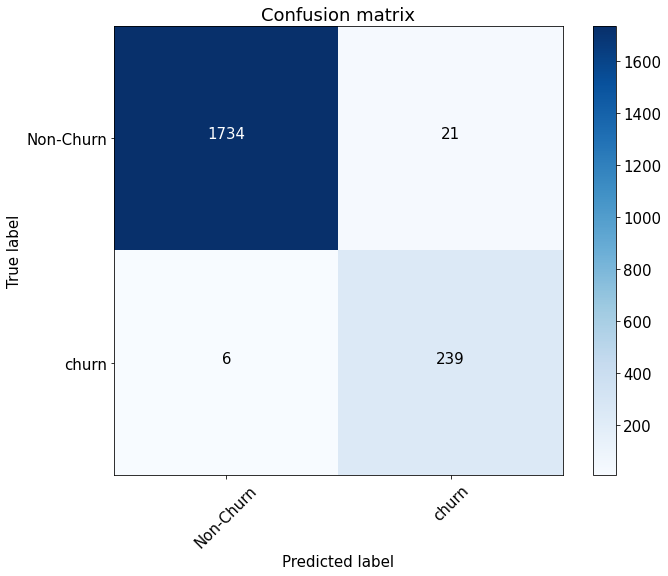

In [80]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_2 = confusion_matrix(y_2_test, preds_2 > thresholds_2[ix_2])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_2, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [81]:
roc_auc_2 = roc_auc_score(y_2_test, preds_2)
roc_auc_2

0.9986231757660329

In [82]:
# 3
# def get_user_embedding(user_articles_list):
#     user_articles_list = eval(user_articles_list)
#     user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
#     user_vector = np.max(user_vector, 0)
#     return user_vector

# to to the cell with the expression 'get_user_embedding(user_articles_list)'
# we've got with max: Best Threshold=0.381851, F-Score=0.786, Precision=0.777, Recall=0.796

In [83]:
def get_user_embedding_3(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  # медиана
    return user_vector

In [85]:
user_articles_list #= users['articles'].iloc[33]

uv_1 = get_user_embedding(user_articles_list) #, doc_dict
uv_2 = get_user_embedding_2(user_articles_list, doc_dict)
uv_3 = get_user_embedding_3(user_articles_list, doc_dict)

print(user_articles_list)
print(uv_1)
print(uv_2)
print(uv_3)

[323329, 321961, 324743, 323186, 324632, 474690]
[0.18716787 0.09378541 0.14574042 0.09412808 0.         0.04461601
 0.01421521 0.         0.0182828  0.         0.00967194 0.
 0.         0.00694903 0.0480928  0.00255514 0.09300104 0.03044105
 0.04064438 0.01435156 0.01656339 0.05417466 0.00889891 0.02893836
 0.03795088]
[0.15513717 0.05074601 0.04993362 0.0643983  0.         0.
 0.00798113 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01720217 0.
 0.02296885 0.         0.         0.         0.         0.
 0.01618495]
[0.45108801 0.33663112 0.43351549 0.23184422 0.         0.16611645
 0.05196203 0.         0.06026065 0.         0.03790142 0.
 0.         0.02736155 0.28855678 0.01533083 0.3948929  0.1060301
 0.11390609 0.06768082 0.05308654 0.30665341 0.05339343 0.13559216
 0.15119171]


In [86]:
%%time
user_embeddings_3 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_3(x, doc_dict))])
user_embeddings_3.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_3['uid'] = users['uid'].values
user_embeddings_3 = user_embeddings_3[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings_3.head(3)

CPU times: user 316 ms, sys: 5.83 ms, total: 322 ms
Wall time: 322 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.191468,0.267059,0.071999,0.231648,0.099449,0.174830,0.162903,0.321116,...,0.144855,0.131942,0.174077,0.161391,0.047191,0.000000,0.041817,0.158387,0.101417,0.163154
1,u108690,0.153695,0.089838,0.343897,0.182331,0.056998,0.214476,0.087359,0.081202,0.087641,...,0.081996,0.297224,0.147784,0.062458,0.046752,0.095065,0.075668,0.187759,0.107266,0.165702
2,u108339,0.211432,0.296806,0.270804,0.024852,0.032713,0.109306,0.041065,0.013635,0.093576,...,0.042105,0.296396,0.040868,0.273968,0.093536,0.050851,0.264885,0.000000,0.076356,0.257398


In [87]:
user_embeddings_3.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.191468,0.267059,0.071999,0.231648,0.099449,0.174830,0.162903,0.321116,...,0.144855,0.131942,0.174077,0.161391,0.047191,0.000000,0.041817,0.158387,0.101417,0.163154
1,u108690,0.153695,0.089838,0.343897,0.182331,0.056998,0.214476,0.087359,0.081202,0.087641,...,0.081996,0.297224,0.147784,0.062458,0.046752,0.095065,0.075668,0.187759,0.107266,0.165702
2,u108339,0.211432,0.296806,0.270804,0.024852,0.032713,0.109306,0.041065,0.013635,0.093576,...,0.042105,0.296396,0.040868,0.273968,0.093536,0.050851,0.264885,0.000000,0.076356,0.257398
3,u101138,0.037286,0.068989,0.151591,0.080126,0.011902,0.411297,0.019131,0.000000,0.164874,...,0.047724,0.018810,0.674173,0.080063,0.258685,0.259594,0.124559,0.311570,0.248072,0.134458
4,u108248,0.077043,0.129109,0.231636,0.066294,0.166644,0.456713,0.101700,0.132212,0.174523,...,0.402360,0.106415,0.059356,0.135984,0.268891,0.136115,0.011465,0.098109,0.027201,0.122890


In [88]:
X_3 = pd.merge(user_embeddings_3, target, 'left')
X_3.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.191468,0.267059,0.071999,0.231648,0.099449,0.174830,0.162903,0.321116,...,0.131942,0.174077,0.161391,0.047191,0.000000,0.041817,0.158387,0.101417,0.163154,0
1,u108690,0.153695,0.089838,0.343897,0.182331,0.056998,0.214476,0.087359,0.081202,0.087641,...,0.297224,0.147784,0.062458,0.046752,0.095065,0.075668,0.187759,0.107266,0.165702,1
2,u108339,0.211432,0.296806,0.270804,0.024852,0.032713,0.109306,0.041065,0.013635,0.093576,...,0.296396,0.040868,0.273968,0.093536,0.050851,0.264885,0.000000,0.076356,0.257398,1


In [89]:
# разделим данные на train/test
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_3['churn'], random_state=0)

In [90]:
# logreg_3 = LogisticRegression()
logreg_3 = RandomForestClassifier()
# обучим 
logreg_3.fit(X_3_train, y_3_train)

RandomForestClassifier()

In [91]:
# наши прогнозы для тестовой выборки
preds_3 = logreg_3.predict_proba(X_3_test)[:, 1]
preds_3[:10]

array([0.04, 0.03, 0.67, 0.21, 0.06, 0.03, 0.15, 0.  , 0.06, 0.1 ])

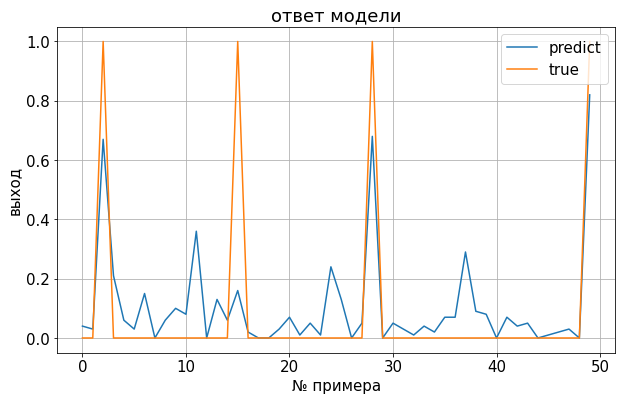

In [92]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds_3[:n], label='predict')
plt.plot(y_3_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [96]:
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_test, preds_3)
# print(precision_2 + recall_2)
fscore_3 = (2 * precision_3 * recall_3) / (precision_3 + recall_3)
# locate the index of the largest f score
ix_3 = np.argmax(fscore_3)
print(f'Best Threshold={thresholds_3[ix_3]}, F-Score={fscore_3[ix_3]:.3f}, Precision={precision_3[ix_3]:.3f}, Recall={recall_3[ix_3]:.3f}')

Best Threshold=0.38, F-Score=0.849, Precision=0.888, Recall=0.812


Confusion matrix, without normalization
[[1732   23]
 [  49  196]]


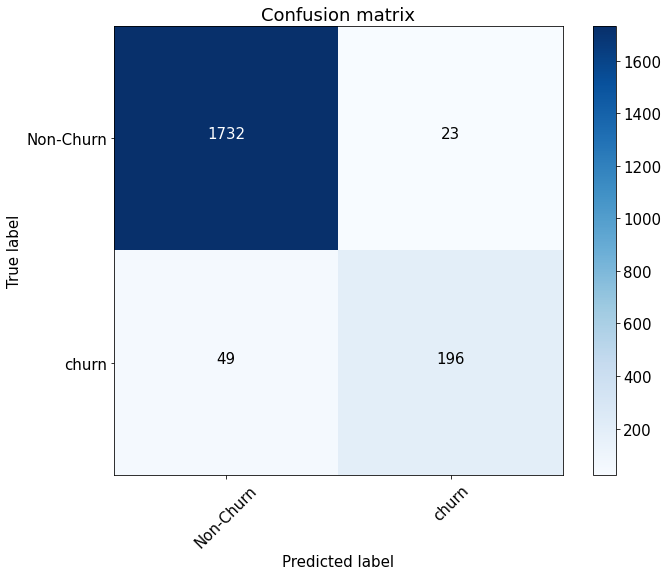

In [97]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_3 = confusion_matrix(y_3_test, preds_3 > thresholds_3[ix_3])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_3, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [98]:
roc_auc_3 = roc_auc_score(y_3_test, preds_3)
roc_auc_3

0.9848781905924763

In [99]:
# 4
from gensim.models import LdaModel, TfidfModel

In [100]:
# Считаем tf-idf значения для каждого слова в каждом документе.

tfidf_model = TfidfModel(common_corpus)
common_corpus_tfidf = [tfidf_model[doc] for doc in common_corpus]

In [101]:
# Тренируем LDA на tf-idf корпусе.

lda_tfidf = LdaModel(common_corpus_tfidf, num_topics=25, id2word=common_dictionary)

In [102]:
# Получаем эмбеддинги документов по темам, с учетом подсчета для нового документа значений tf-idf.
def get_lda_vector_tfidf(text):
    unseen_doc = tfidf_model[common_dictionary.doc2bow(text)]
    lda_tuple = lda_tfidf[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [103]:
topic_matrix_tfidf = pd.DataFrame([get_lda_vector_tfidf(text) for text in news['title'].values])
topic_matrix_tfidf.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix_tfidf['doc_id'] = news['doc_id'].values
topic_matrix_tfidf = topic_matrix_tfidf[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
doc_dict = dict(zip(topic_matrix_tfidf['doc_id'].values, topic_matrix_tfidf[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [106]:
%%time
user_embeddings_4 = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x))])
user_embeddings_4.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_4['uid'] = users['uid'].values
user_embeddings_4 = user_embeddings_4[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings_4.head(3)

CPU times: user 671 ms, sys: 23 ms, total: 694 ms
Wall time: 1.87 s


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.032328,0.014736,0.256767,0.005440,0.018624,0.066716,0.044027,0.022171,0.000000,...,0.004277,0.000000,0.007250,0.007395,0.005410,0.017524,0.009548,0.286872,0.002411,0.058436
1,u108690,0.051002,0.027410,0.264127,0.008095,0.026447,0.020236,0.008625,0.022488,0.008339,...,0.000000,0.002313,0.006015,0.000000,0.000000,0.005999,0.022783,0.266347,0.027274,0.109621
2,u108339,0.092332,0.021524,0.215286,0.005382,0.011143,0.010775,0.004398,0.026316,0.000000,...,0.002013,0.000000,0.000000,0.006863,0.019816,0.007536,0.010658,0.246087,0.014881,0.127154


In [107]:
user_embeddings_4.head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.032328,0.014736,0.256767,0.005440,0.018624,0.066716,0.044027,0.022171,0.000000,...,0.004277,0.000000,0.007250,0.007395,0.005410,0.017524,0.009548,0.286872,0.002411,0.058436
1,u108690,0.051002,0.027410,0.264127,0.008095,0.026447,0.020236,0.008625,0.022488,0.008339,...,0.000000,0.002313,0.006015,0.000000,0.000000,0.005999,0.022783,0.266347,0.027274,0.109621
2,u108339,0.092332,0.021524,0.215286,0.005382,0.011143,0.010775,0.004398,0.026316,0.000000,...,0.002013,0.000000,0.000000,0.006863,0.019816,0.007536,0.010658,0.246087,0.014881,0.127154
3,u101138,0.014956,0.050296,0.331950,0.000000,0.002046,0.004154,0.012329,0.007435,0.018179,...,0.031268,0.003911,0.000000,0.000000,0.003178,0.005506,0.035400,0.136519,0.004063,0.112608
4,u108248,0.110883,0.035814,0.297913,0.013168,0.002652,0.023106,0.004110,0.014148,0.011117,...,0.006051,0.002608,0.006848,0.002342,0.004056,0.013191,0.013975,0.193747,0.033705,0.092680


In [108]:
X_4 = pd.merge(user_embeddings_4, target, 'left')
X_4.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.032328,0.014736,0.256767,0.005440,0.018624,0.066716,0.044027,0.022171,0.000000,...,0.000000,0.007250,0.007395,0.005410,0.017524,0.009548,0.286872,0.002411,0.058436,0
1,u108690,0.051002,0.027410,0.264127,0.008095,0.026447,0.020236,0.008625,0.022488,0.008339,...,0.002313,0.006015,0.000000,0.000000,0.005999,0.022783,0.266347,0.027274,0.109621,1
2,u108339,0.092332,0.021524,0.215286,0.005382,0.011143,0.010775,0.004398,0.026316,0.000000,...,0.000000,0.000000,0.006863,0.019816,0.007536,0.010658,0.246087,0.014881,0.127154,1


In [109]:
# разделим данные на train/test
X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_4['churn'], random_state=0)

In [110]:
# logreg_4 = LogisticRegression(random_state=0) # LogisticRegression выдавал предсказания, которые не позволяли рассчитать f1 score
logreg_4 = RandomForestClassifier()
# обучим 
logreg_4.fit(X_4_train, y_4_train)

RandomForestClassifier()

In [111]:
# наши прогнозы для тестовой выборки
preds_4 = logreg_4.predict_proba(X_4_test)[:, 1]
preds_4[:10]

array([0.35, 0.04, 0.34, 0.08, 0.08, 0.01, 0.04, 0.03, 0.1 , 0.25])

In [112]:
print(preds_4)

[0.35 0.04 0.34 ... 0.02 0.06 0.  ]


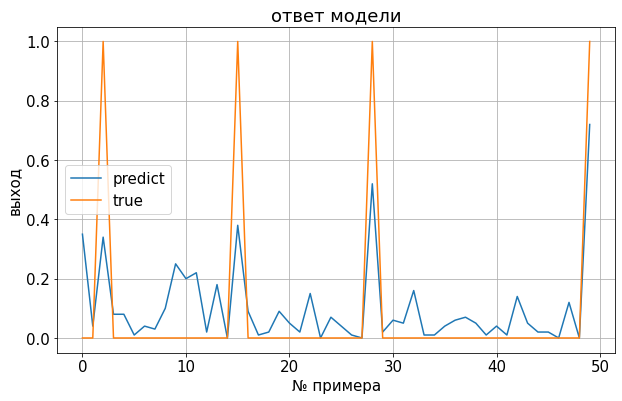

In [113]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds_4[:n], label='predict')
plt.plot(y_4_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [115]:
# precision_4, recall_4, thresholds_4 = precision_recall_curve(y_test, np.round(abs(preds_4))) #preds_4)
precision_4, recall_4, thresholds_4 = precision_recall_curve(y_test, preds_4)
fscore_4 = (2 * precision_4 * recall_4) / (precision_4 + recall_4)
# locate the index of the largest f score
ix_4 = np.argmax(fscore_4)
print(f'Best Threshold={thresholds_4[ix_4]}, F-Score={fscore_4[ix_4]:.3f}, Precision={precision_4[ix_4]:.3f}, Recall={recall_4[ix_4]:.3f}')

Best Threshold=0.29, F-Score=0.701, Precision=0.643, Recall=0.771


Confusion matrix, without normalization
[[1655  100]
 [  60  185]]


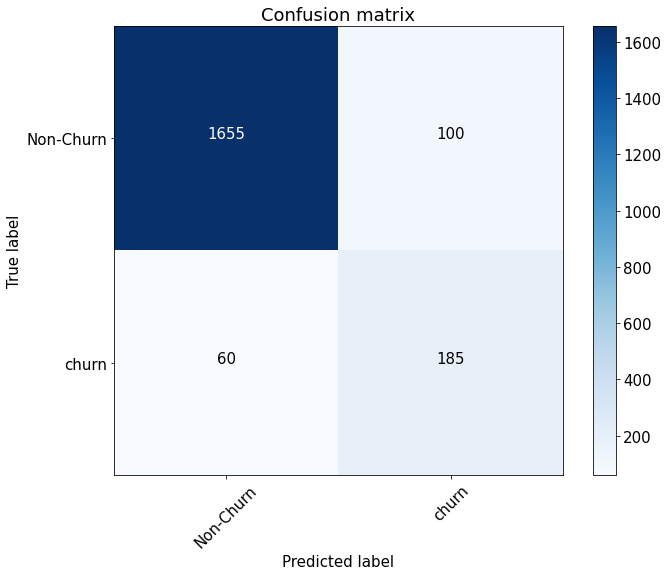

In [116]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_4 = confusion_matrix(y_4_test, preds_4 > thresholds_4[ix_4])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_4, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [117]:
roc_auc_4 = roc_auc_score(y_4_test, preds_4)
roc_auc_4

0.9392836792836792

In [120]:
#5
df=pd.DataFrame(
    {
        'methods':['mean', 'median','max','idf_mean ']
        ,'roc_auc':[roc_auc, roc_auc_2, roc_auc_3, roc_auc_4]
        ,'precision': [precision[ix], precision_2[ix_2], precision_3[ix_3], precision_4[ix_4]]
        ,'recall': [recall[ix], recall_2[ix_2], recall_3[ix_3], recall_4[ix_4]]
        ,'f_score': [fscore[ix], fscore_2[ix_2], fscore_3[ix_3], fscore_4[ix_4]]
    }
)
df

,methods,roc_auc,precision,recall,f_score
0,mean,0.952172,0.639073,0.787755,0.705667
1,median,0.998623,0.916031,0.979592,0.946746
2,max,0.984878,0.888393,0.812245,0.848614
3,idf_mean,0.939284,0.642857,0.771429,0.701299


In [121]:
# 6
# Можно заметить, что получение user embeddings по медиане сработало лучше, чем по максимальному значению или среднему.
# Получение embeddings по медиане работает лучше, т.к. сама медиана более устойчива к выбросам. И случайно просмотренная 
# статья с "тяжелой" тематикой может значительно изменить предсказания алгоритма. Но не в случае медианы.
#Среднее по tf-idf сработало хуже чем любой bag-of-words. Возможно тексты в данном датасете слишком короткие, что ухудшает 
# качество работы tf-idf.

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk